# California Housing Price Prediction

The purpose of the project is to predict median house values in Californian districts, given many features from these districts.

## Importing Libraries

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

## Reading data

In [44]:
housing = pd.read_csv("input/housingCalifornia.csv")

## Basic Data Analysis or Exploratory Data Analysis

In [45]:
print("The number of rows and colums are {} and also called shape of the matrix".format(housing.shape))
print("Columns names are \n {}".format(housing.columns))


The number of rows and colums are (20640, 10) and also called shape of the matrix
Columns names are 
 Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')


In [46]:
print(housing.head())


   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  


In [47]:
print(housing.tail())

       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
20635    -121.09     39.48                25.0       1665.0           374.0   
20636    -121.21     39.49                18.0        697.0           150.0   
20637    -121.22     39.43                17.0       2254.0           485.0   
20638    -121.32     39.43                18.0       1860.0           409.0   
20639    -121.24     39.37                16.0       2785.0           616.0   

       population  households  median_income  median_house_value  \
20635       845.0       330.0         1.5603             78100.0   
20636       356.0       114.0         2.5568             77100.0   
20637      1007.0       433.0         1.7000             92300.0   
20638       741.0       349.0         1.8672             84700.0   
20639      1387.0       530.0         2.3886             89400.0   

      ocean_proximity  
20635          INLAND  
20636          INLAND  
20637          INLAND  
20638          INLAN

In [48]:
print(housing.dtypes)

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object


#### The median house values are continuous and hence it is a regression problem
#### One of the column is a categorical feature (ocean_proximity)

<Figure size 640x480 with 0 Axes>

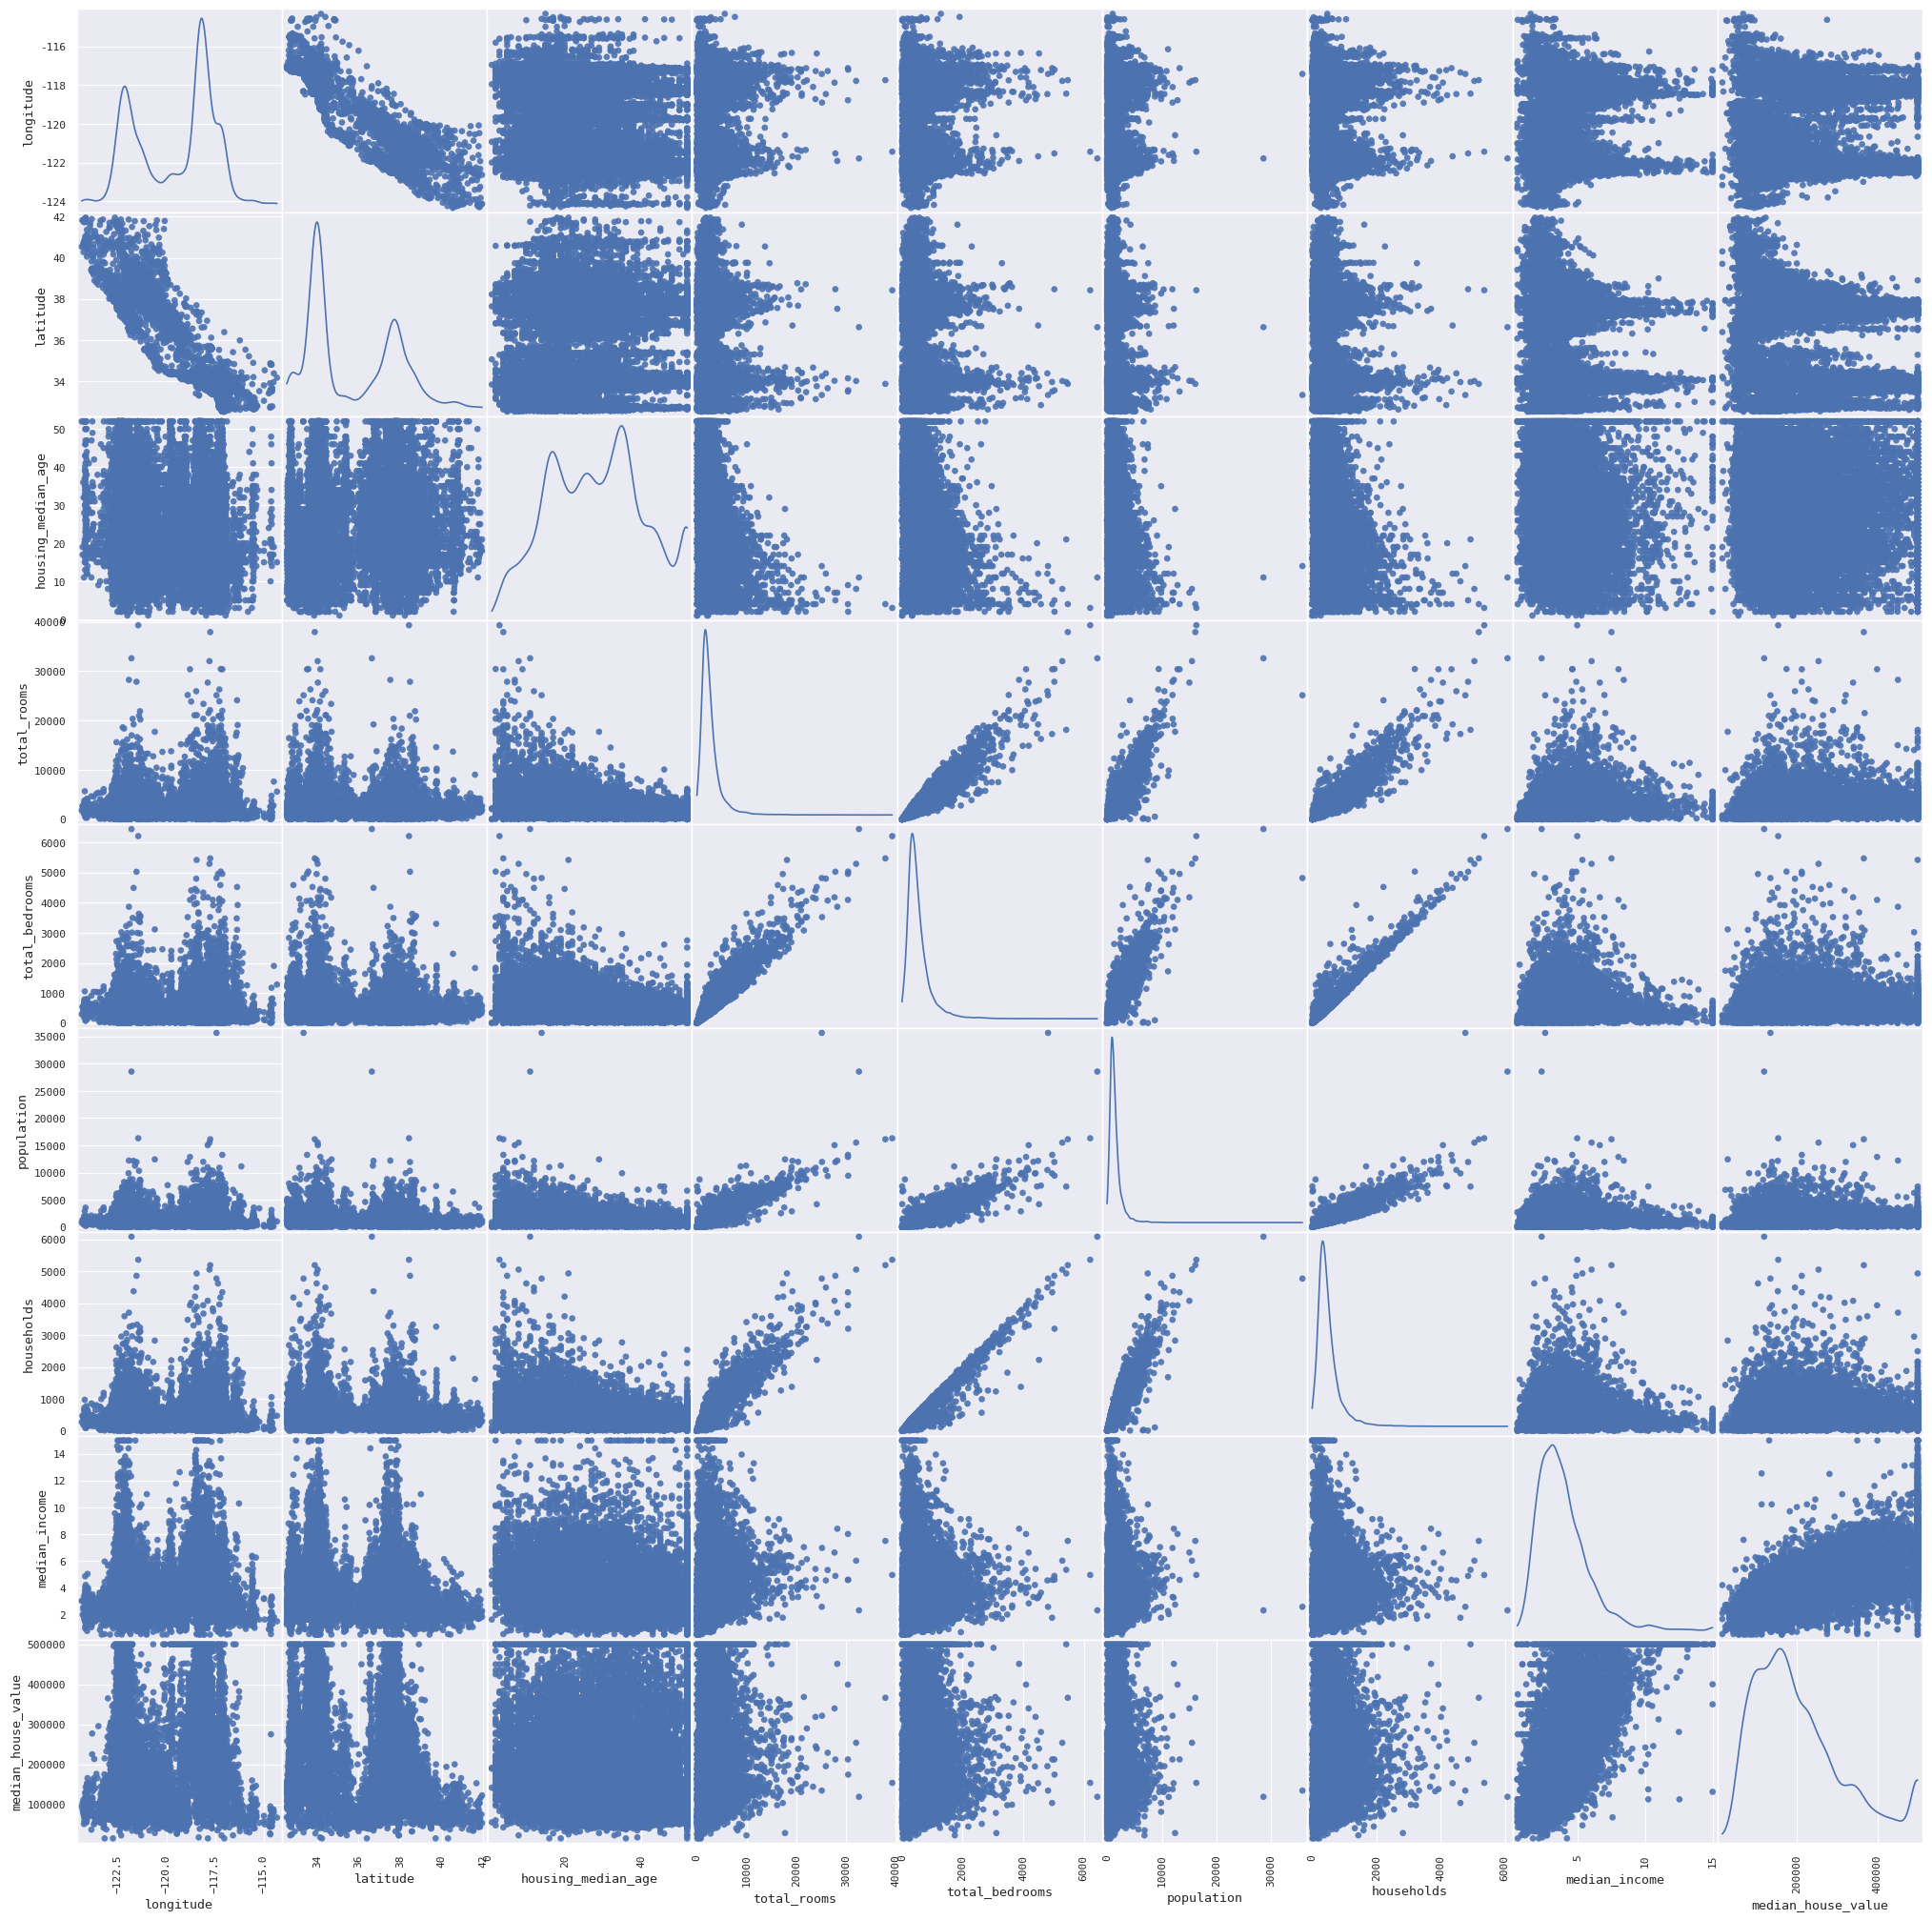

In [49]:
#display scatter_matrix also
fig = plt.figure()
scatter_matrix(housing,figsize =(25,25),alpha=0.9,diagonal="kde",marker="o");


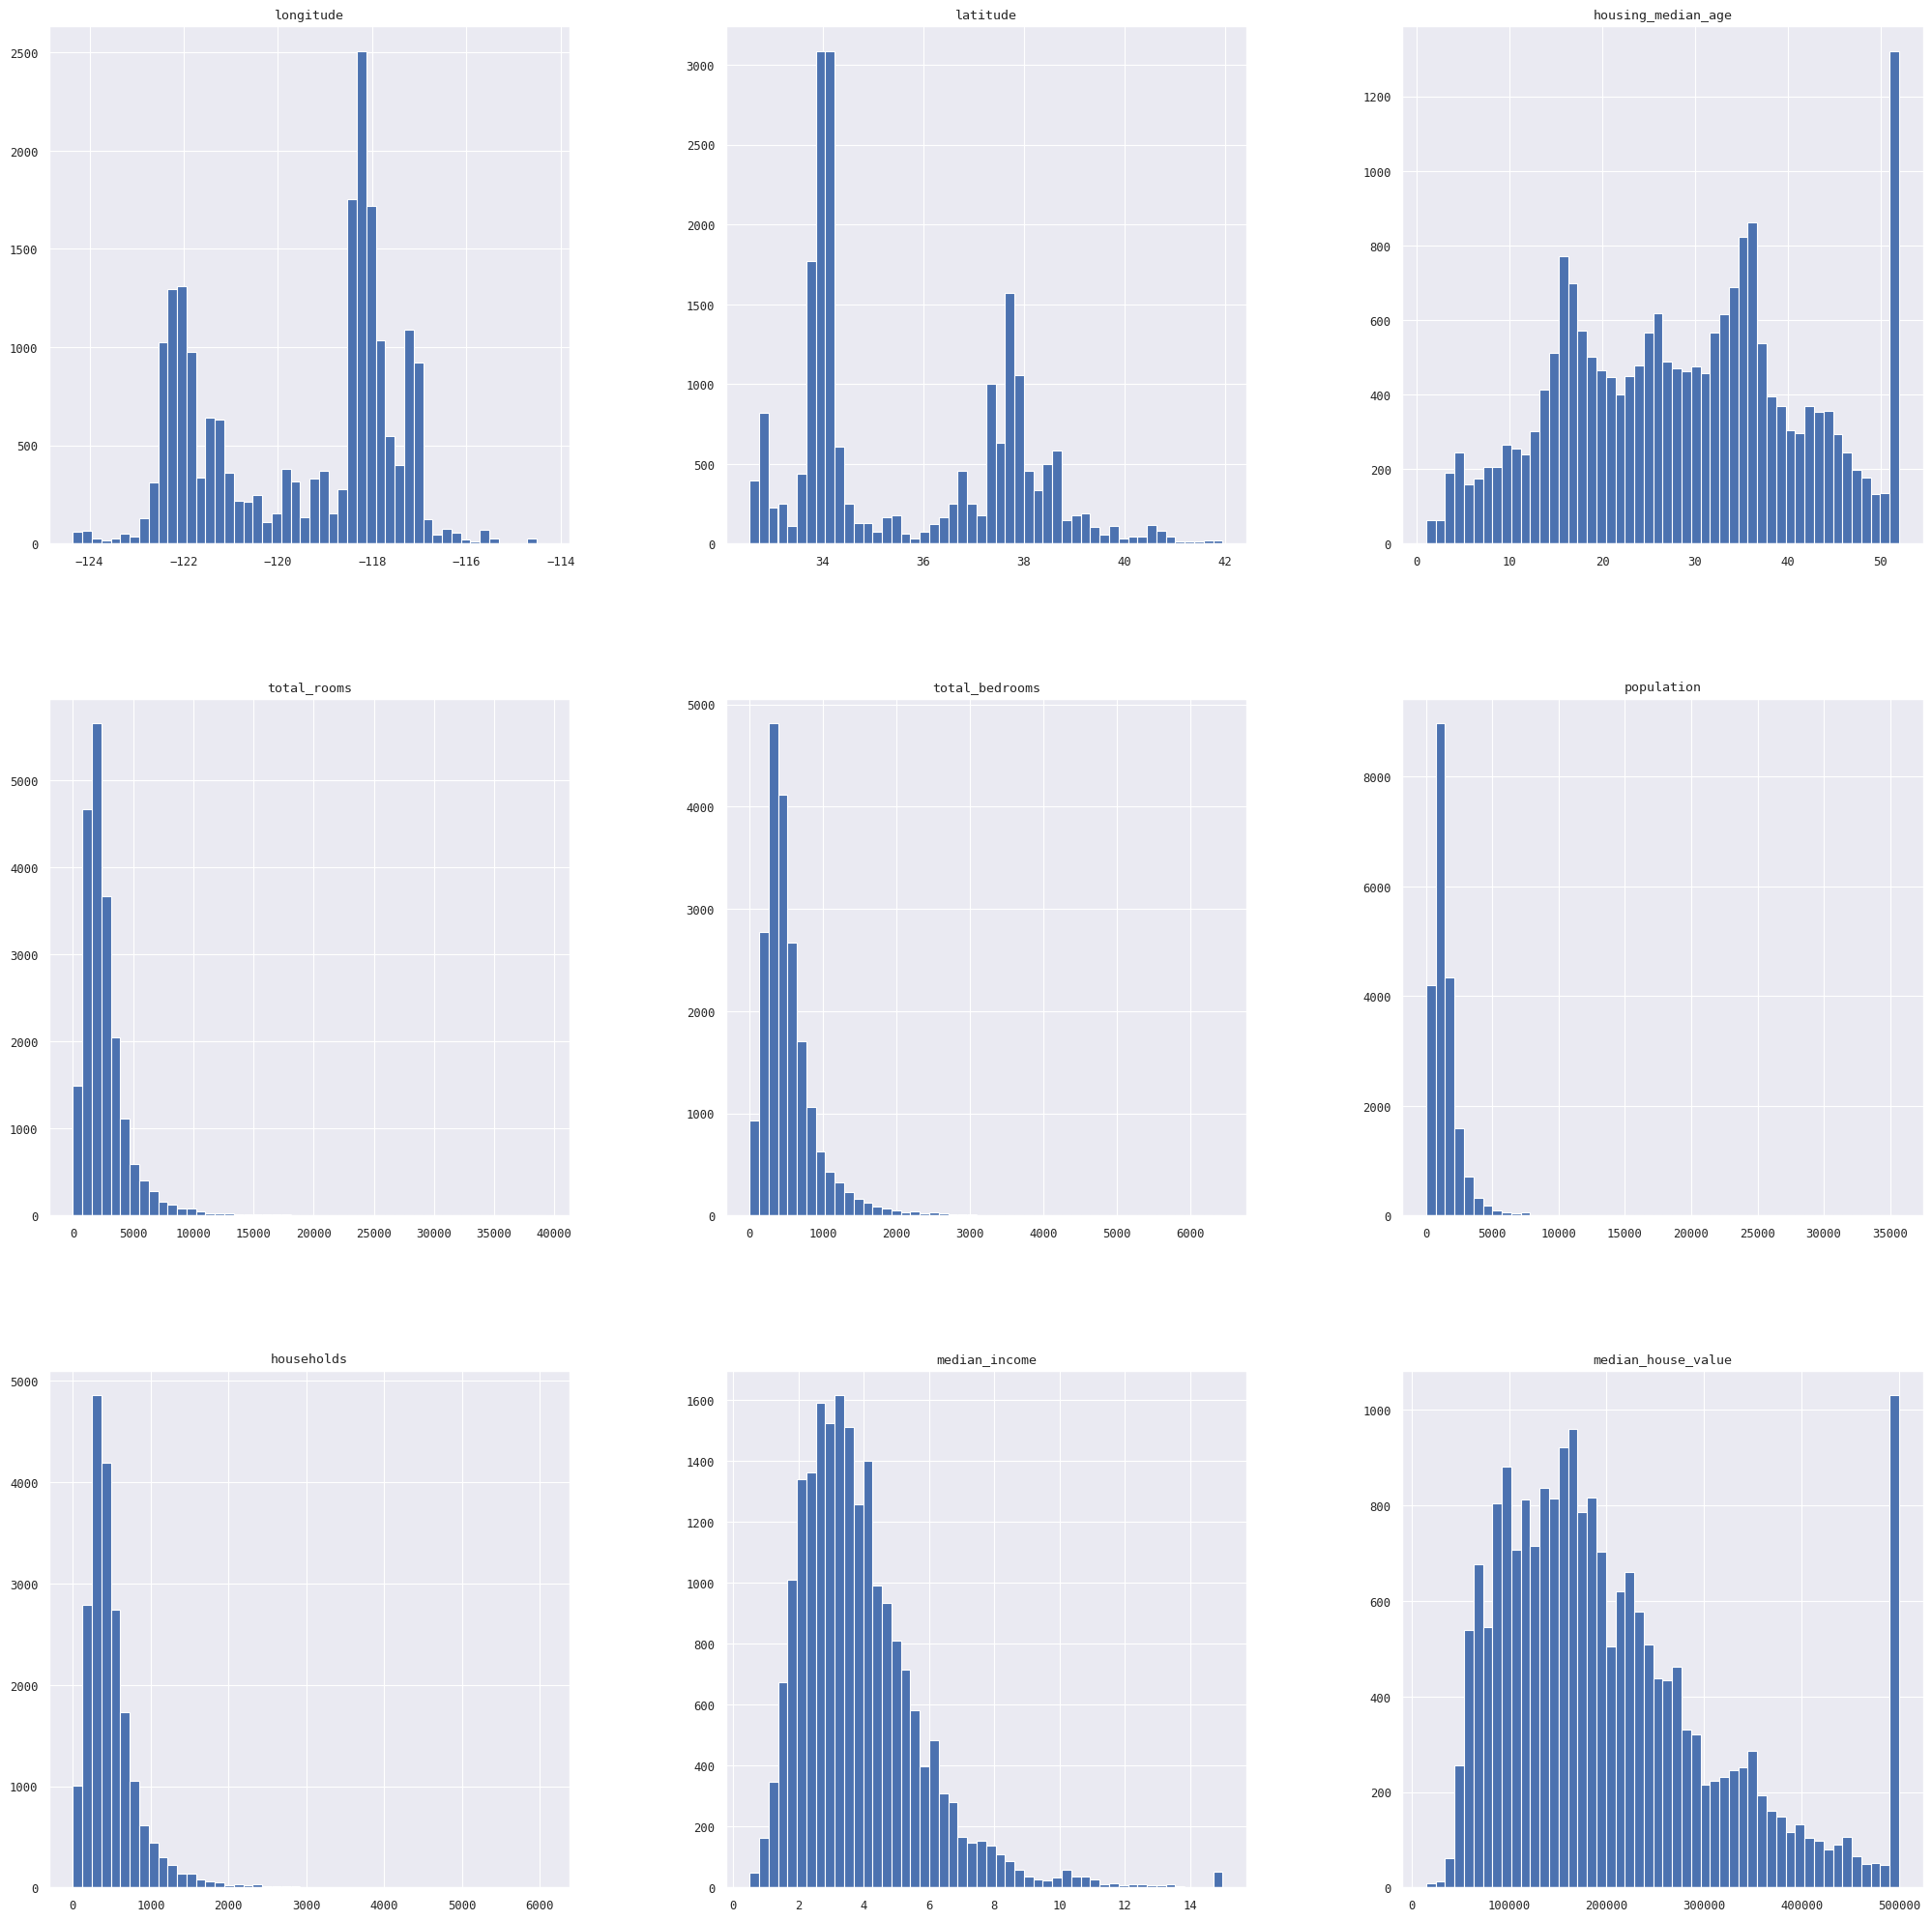

In [50]:
housing.hist(figsize=(25,25),bins=50);

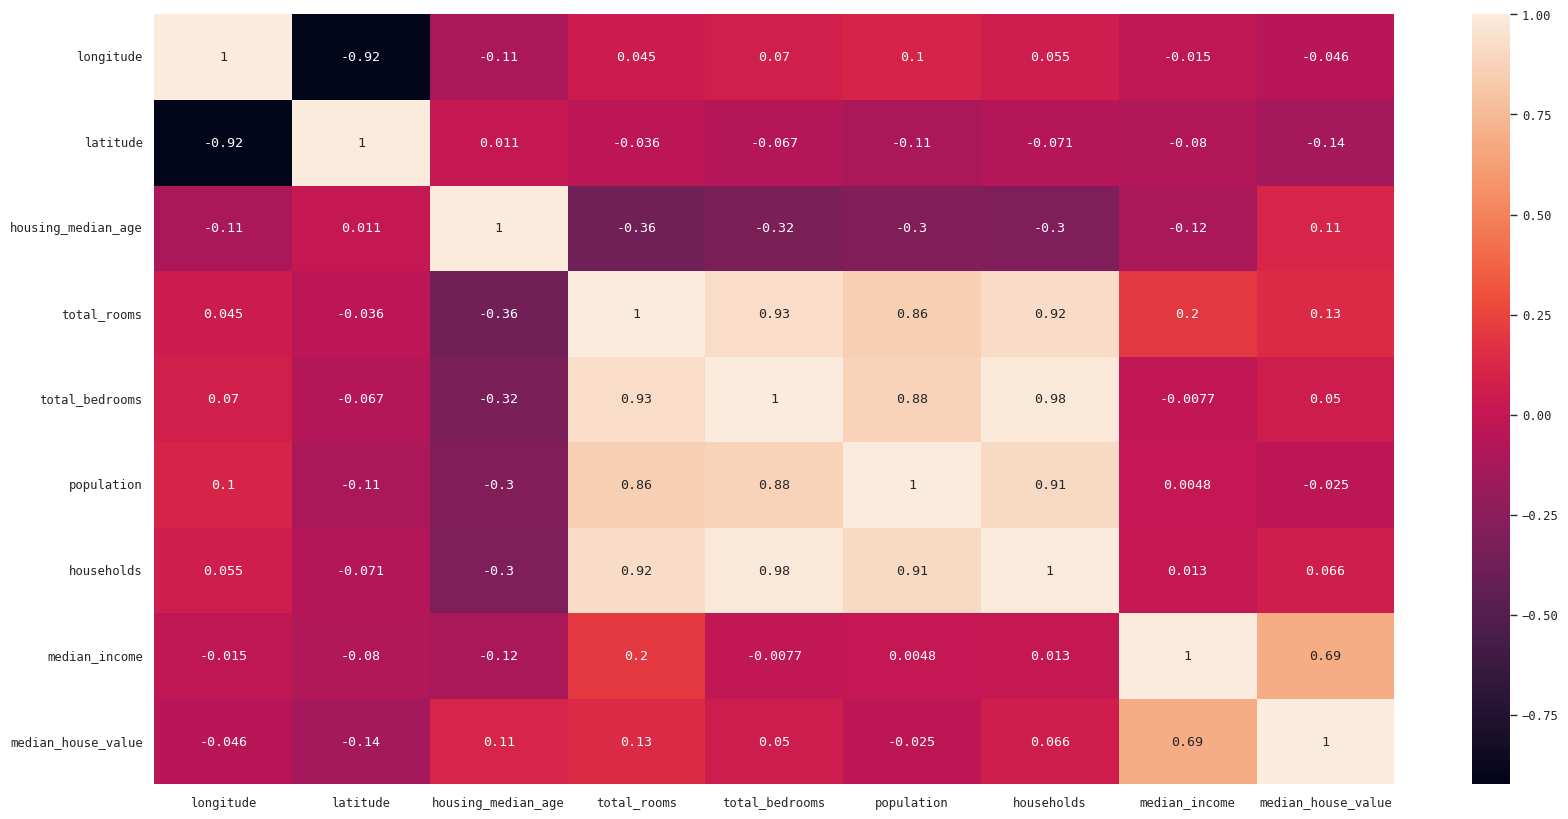

In [51]:
numeric_data = housing.select_dtypes(include='number')

# Create the heatmap using only numeric columns
plt.figure(figsize=(20, 10))
sns.heatmap(numeric_data.corr(), annot=True)
plt.show()

### Get the Outliers

In [52]:
def getOutliers(dataframe,column):
    column = "total_rooms" 
    #housing[column].plot.box(figsize=(8,8))
    des = dataframe[column].describe()
    desPairs = {"count":0,"mean":1,"std":2,"min":3,"25":4,"50":5,"75":6,"max":7}
    Q1 = des[desPairs['25']]
    Q3 = des[desPairs['75']]
    IQR = Q3-Q1
    lowerBound = Q1-1.5*IQR
    upperBound = Q3+1.5*IQR
    print("(IQR = {})Outlier are anything outside this range: ({},{})".format(IQR,lowerBound,upperBound))
    #b = df[(df['a'] > 1) & (df['a'] < 5)]
    data = dataframe[(dataframe [column] < lowerBound) | (dataframe [column] > upperBound)]

    print("Outliers out of total = {} are \n {}".format(housing[column].size,len(data[column])))
    #remove the outliers from the dataframe
    outlierRemoved = housing[~housing[column].isin(data[column])]
    return outlierRemoved

In [53]:
#get the outlier
df_outliersRemoved = getOutliers(housing,"total_rooms")

(IQR = 1700.25)Outlier are anything outside this range: (-1102.625,5698.375)
Outliers out of total = 20640 are 
 1287


## Impute the missing values in the data set

In [54]:
#check wheather there are any missing values or null
housing.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [55]:
#Total_bedrooms columns is having 207 missing values
#Now we need to impute the missing values

In [56]:
#statistics for missing values
print ("Total_bedrooms column Mode is  "+str(housing["total_bedrooms"].mode())+"\n")
print(housing["total_bedrooms"].describe())

Total_bedrooms column Mode is  0    280.0
Name: total_bedrooms, dtype: float64

count    20433.000000
mean       537.870553
std        421.385070
min          1.000000
25%        296.000000
50%        435.000000
75%        647.000000
max       6445.000000
Name: total_bedrooms, dtype: float64


<Axes: >

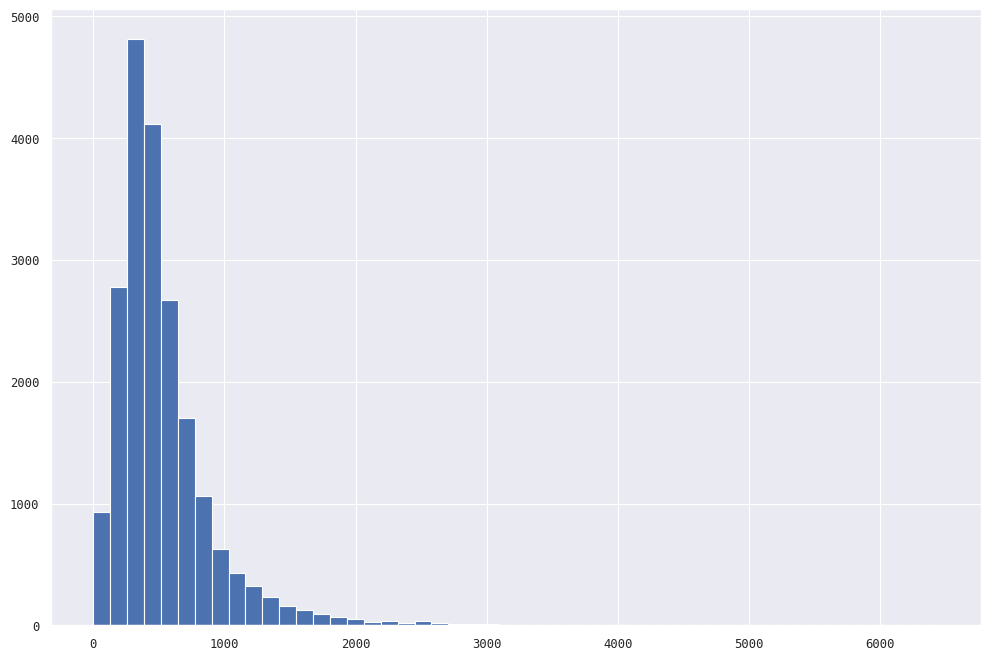

In [57]:
total_bedroms = housing[housing["total_bedrooms"].notnull()]["total_bedrooms"]#["total_bedrooms"]
total_bedroms.hist(figsize=(12,8),bins=50)

In [58]:
#mendefinisikan strategi untuk mencari value yang hilang (menggunakan metode median)
imputer = SimpleImputer(strategy ="median")

#mempelajari nilai median dari kolom ke-5 (total_bedrooms)
imputer.fit(housing.iloc[:,4:5])

#mengisi nilai yang hilang dalam kolom ke-5 dengan nilai median yang telah dipelajari sebelumnya menggunakan fit
housing.iloc[:,4:5] = imputer.transform(housing.iloc[:,4:5])

In [59]:
## Label encode for categorical feature (ocean_proximity)

In [60]:
labelEncoder = LabelEncoder()
print(housing["ocean_proximity"].value_counts())
housing["ocean_proximity"] = labelEncoder.fit_transform(housing["ocean_proximity"])
housing["ocean_proximity"].value_counts()
housing.describe()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,536.838857,1425.476744,499.539680,3.870671,206855.816909,1.165843
std,2.003532,2.135952,12.585558,2181.615252,419.391878,1132.462122,382.329753,1.899822,115395.615874,1.420662
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.000000
25%,-121.800000,33.930000,18.000000,1447.750000,297.000000,787.000000,280.000000,2.563400,119600.000000,0.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000,1.000000
75%,-118.010000,37.710000,37.000000,3148.000000,643.250000,1725.000000,605.000000,4.743250,264725.000000,1.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,4.000000


## Split the dataset into 80% train and 20% test dataset

In [61]:
housing_ind = housing.drop("median_house_value",axis=1)
print(housing_ind.head())
housing_dep = housing["median_house_value"]
print("Medain Housing Values")
print(housing_dep.head())

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  ocean_proximity  
0       322.0       126.0         8.3252                3  
1      2401.0      1138.0         8.3014                3  
2       496.0       177.0         7.2574                3  
3       558.0       219.0         5.6431                3  
4       565.0       259.0         3.8462                3  
Medain Housing Values
0    452600.0
1    358500.0
2    352100.0
3    341300.0
4    342200.0
Name: median_house_value, dtype: float64


In [62]:
#check for rand_state
X_train,X_test,y_train,y_test = train_test_split(housing_ind,housing_dep,test_size=0.2,random_state=42)
#print(X_train.head())
#print(X_test.head())
#print(y_train.head())
#print(y_test.head())
print("X_train shape {} and size {}".format(X_train.shape,X_train.size))
print("X_test shape {} and size {}".format(X_test.shape,X_test.size))
print("y_train shape {} and size {}".format(y_train.shape,y_train.size))
print("y_test shape {} and size {}".format(y_test.shape,y_test.size))


X_train shape (16512, 9) and size 148608
X_test shape (4128, 9) and size 37152
y_train shape (16512,) and size 16512
y_test shape (4128,) and size 4128


In [63]:
X_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,4
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,4
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,4
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,4
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,1


## Standardize the data 

In [64]:
#Standardize training and test datasets.
#==============================================================================
# Feature scaling is to bring all the independent variables in a dataset into
# same scale, to avoid any variable dominating  the model. Here we will not 
# transform the dependent variables.
#==============================================================================
independent_scaler = StandardScaler()
X_train = independent_scaler.fit_transform(X_train)
X_test = independent_scaler.transform(X_test)
print(X_train[0:5,:])
print("test data")
print(X_test[0:5,:])

[[ 1.27258656 -1.3728112   0.34849025  0.22256942  0.21122752  0.76827628
   0.32290591 -0.326196    2.00593172]
 [ 0.70916212 -0.87669601  1.61811813  0.34029326  0.59309419 -0.09890135
   0.6720272  -0.03584338  2.00593172]
 [-0.44760309 -0.46014647 -1.95271028 -0.34259695 -0.49522582 -0.44981806
  -0.43046109  0.14470145  2.00593172]
 [ 1.23269811 -1.38217186  0.58654547 -0.56148971 -0.40930582 -0.00743434
  -0.38058662 -1.01786438  2.00593172]
 [-0.10855122  0.5320839   1.14200767 -0.11956547 -0.25655915 -0.48587717
  -0.31496232 -0.17148831 -0.1124266 ]]
test data
[[ 0.28534728  0.1951     -0.28632369 -0.52286157 -0.24701249 -0.03030109
  -0.37008673 -1.15508475 -0.1124266 ]
 [ 0.06097472 -0.23549054  0.11043502  0.13841528 -0.24701249  0.12185077
   0.220532   -0.70865905 -0.1124266 ]
 [-1.42487026  1.00947776  1.85617335  0.54630997 -0.24701249 -0.10241931
   1.21539643 -0.21040155  1.29981228]
 [ 0.42994293 -0.63799909 -0.92113763  0.18808002 -0.24701249  0.24497944
  -0.013090

## Perform Linear Regression
Perform Linear Regression on training data.
Predict output for test dataset using the fitted model.
Print root mean squared error (RMSE) from Linear Regression.
(HINT: Import mean_squared_error from sklearn.metrics)


In [65]:
#initantiate the linear regression
linearRegModel = LinearRegression(n_jobs=-1)
#fit the model to the training data (learn the coefficients)
linearRegModel.fit(X_train,y_train)
#print the intercept and coefficients 
print("Intercept is "+str(linearRegModel.intercept_))
print("coefficients  is "+str(linearRegModel.coef_))

Intercept is 207194.69373788778
coefficients  is [-85854.94724101 -90946.06271148  14924.30655143 -17693.23405277
  48767.60670995 -43884.16852449  17601.31495096  77144.10164179
   -451.52015229]


In [66]:
#predict on the test data
y_pred = linearRegModel.predict(X_test)

In [67]:
print(len(y_pred))
print(len(y_test))
print(y_pred[0:5])
print(y_test[0:5])


4128
4128
[ 63642.8756283  154445.82484211 252777.76132135 263796.86435521
 266307.35634572]
20046     47700.0
3024      45800.0
15663    500001.0
20484    218600.0
9814     278000.0
Name: median_house_value, dtype: float64


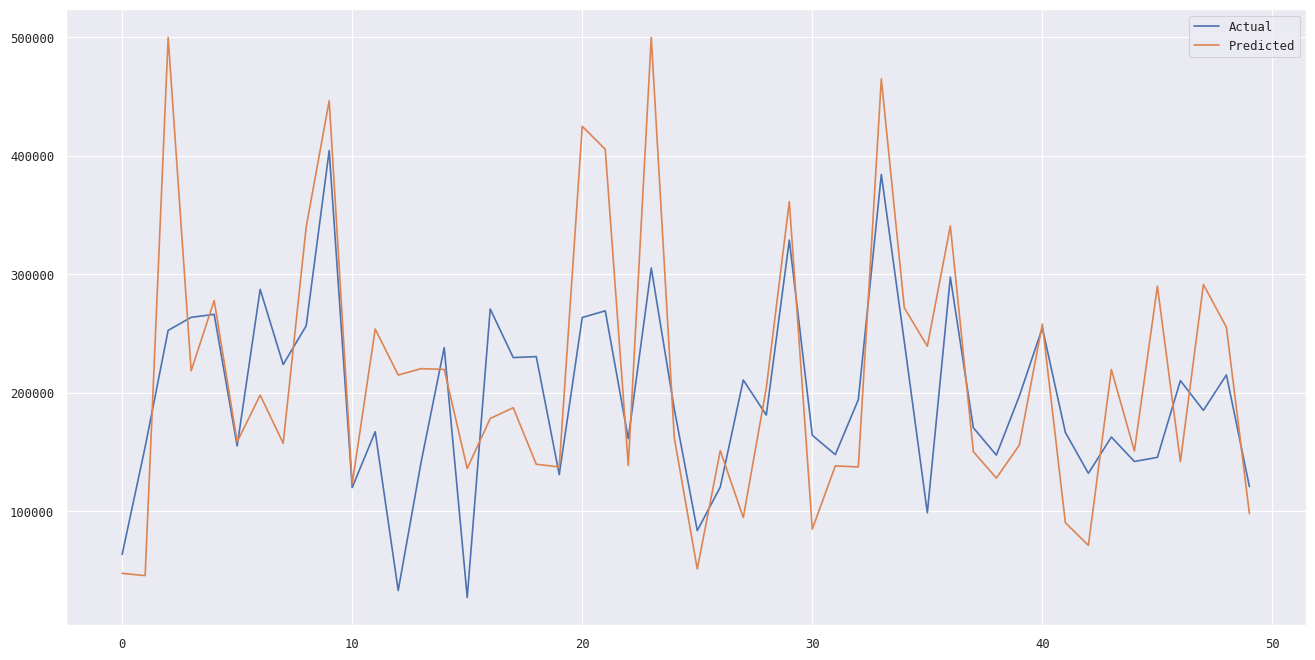

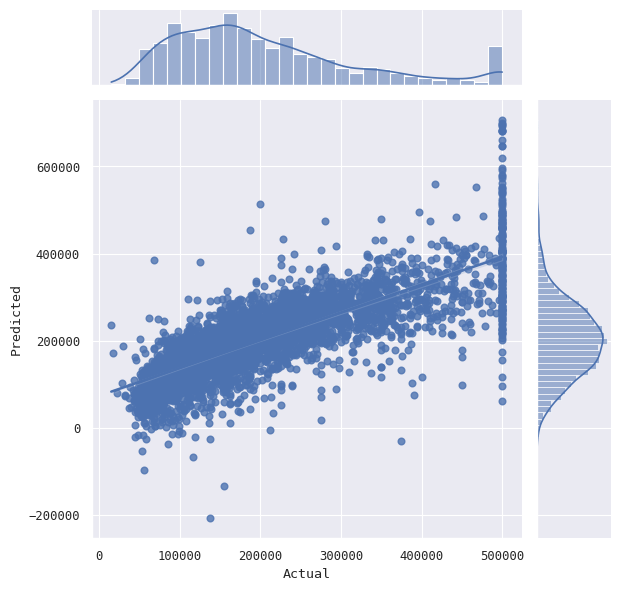

In [68]:
test = pd.DataFrame({'Predicted':y_pred,'Actual':y_test})
fig= plt.figure(figsize=(16,8))
test = test.reset_index()
test = test.drop(['index'],axis=1)
plt.plot(test[:50])
plt.legend(['Actual','Predicted'])
sns.jointplot(x='Actual',y='Predicted',data=test,kind='reg',);

####   Root Mean Squared Error (RMSE)

In [69]:
print(np.sqrt(metrics.mean_squared_error(y_test,y_pred)))
print(np.sqrt(metrics.mean_squared_error(y_train,linearRegModel.predict(X_train))))


NameError: name 'metrics' is not defined

## Perform Decision Tree Regression
Perform Decision Tree Regression on training data.
Predict output for test dataset using the fitted model.

Print root mean squared error from Decision Tree Regression.

In [ ]:
dtReg = DecisionTreeRegressor(max_depth=9)
dtReg.fit(X_train,y_train)

In [ ]:
dtReg_y_pred = dtReg.predict(X_test)
dtReg_y_pred

In [ ]:
print(len(dtReg_y_pred))
print(len(y_test))
print(dtReg_y_pred[0:5])
print(y_test[0:5])

In [ ]:
print(np.sqrt(metrics.mean_squared_error(y_test,dtReg_y_pred)))

In [ ]:
test = pd.DataFrame({'Predicted':dtReg_y_pred,'Actual':y_test})
fig= plt.figure(figsize=(16,8))
test = test.reset_index()
test = test.drop(['index'],axis=1)
plt.plot(test[:50])
plt.legend(['Actual','Predicted'])
sns.jointplot(x='Actual',y='Predicted',data=test,kind="reg")

## Perform Random Forest Regression
Perform Random Forest Regression on training data.
Predict output for test dataset using the fitted model.
Print RMSE (root mean squared error) from Random Forest Regression.

In [ ]:
rfReg = RandomForestRegressor(30)
rfReg.fit(X_train,y_train)

In [ ]:
rfReg_y_pred = rfReg.predict(X_test)
print(len(rfReg_y_pred))
print(len(y_test))
print(rfReg_y_pred[0:5])
print(y_test[0:5])

In [ ]:
print(np.sqrt(metrics.mean_squared_error(y_test,rfReg_y_pred)))

In [ ]:
test = pd.DataFrame({'Predicted':dtReg_y_pred,'Actual':y_test})
fig= plt.figure(figsize=(16,8))
test = test.reset_index()
test = test.drop(['index'],axis=1)
plt.plot(test[:50])
plt.legend(['Actual','Predicted'])
sns.jointplot(x='Actual',y='Predicted',data=test,kind="reg")

##  Performing Linear Regression with one independent Variable

Extract just the median_income column from the independent 
variables (from X_train and X_test).
Perform Linear Regression to predict housing values based on 
median_income.
Predict output for test dataset using the fitted model.
Plot the fitted model for training data as well as for test data to 
check if the fitted model satisfies the test data.


In [ ]:
#Extract median_income 
dropcol = ["longitude","latitude","housing_median_age","total_rooms","total_bedrooms","population","households","ocean_proximity"]
print(dropcol)
housing_med = housing_ind.drop(dropcol,axis=1)
print(type(housing_med))

In [ ]:
#check for rand_state
X_train2,X_test2,y_train2,y_test2 = train_test_split(housing_med,housing_dep,test_size=0.2,random_state=42)
#print(X_train.head())
#print(X_test.head())
#print(y_train.head())
#print(y_test.head())
print("X_train2 shape {} and size {}".format(X_train2.shape,X_train2.size))
print("X_test2 shape {} and size {}".format(X_test2.shape,X_test2.size))
print("y_train2 shape {} and size {}".format(y_train2.shape,y_train2.size))
print("y_test2 shape {} and size {}".format(y_test2.shape,y_test2.size))

In [ ]:
linReg2 = LinearRegression()
linReg2.fit(X_train2,y_train2)

In [ ]:
y_pred2 = linReg2.predict(X_test2)
print(len(y_pred2))
print(len(y_test2))
print(y_pred2[0:5])
print(y_test2[0:5])

In [ ]:
fig = plt.figure(figsize=(25,8))
plt.scatter(y_test2,y_pred2,marker="o",edgecolors ="r",s=60)
plt.scatter(y_train2,linReg2.predict(X_train2),marker="+",s=50,alpha=0.5)
plt.xlabel(" Actual median_house_value")
plt.ylabel(" Predicted median_house_value")

# Summary

Observations : The median_income , totat_bedrooms have highly skewed data.The data is highly unbalance. 
 